In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import logging
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import rotate
from recnn.recnn import grnn_transform_gated
from recnn.recnn import grnn_predict_gated

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

In [3]:
filename_train = "../data/w-vs-qcd/kt-train.pickle"
filename_test = "../data/w-vs-qcd/kt-test.pickle"
filename_model = "../models/w-vs-qcd-20160614.pickle"

In [4]:
rng = check_random_state(1)

In [5]:
# Make training data
print("Loading training data...")

fd = open(filename_train, "rb")
X, y = pickle.load(fd)
fd.close()
y = np.array(y)

print("\tfilename = %s" % filename_train)
print("\tX size = %d" % len(X))
print("\ty size = %d" % len(y))

Loading training data...
	filename = ../data/w-vs-qcd/kt-train.pickle
	X size = 80000
	y size = 80000


In [6]:
# Preprocessing 
print("Preprocessing...")
X = [rotate(permute_by_pt(jet)) for jet in X]
tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))

for jet in X:
    jet["content"] = tf.transform(jet["content"])

Preprocessing...


In [7]:
# Make test data 
print("Loading test data...")

fd = open(filename_test, "rb")
X, y = pickle.load(fd)
fd.close()
y = np.array(y)

print("\tfilename = %s" % filename_test)
print("\tX size = %d" % len(X))
print("\ty size = %d" % len(y))

Loading test data...
	filename = ../data/w-vs-qcd/kt-test.pickle
	X size = 20000
	y size = 20000


In [8]:
# Preprocessing 
print("Preprocessing...")
X = [rotate(permute_by_pt(jet)) for jet in X]

for jet in X:
    jet["content"] = tf.transform(jet["content"])

Preprocessing...


In [9]:
# Loading model 
print("Loading model...")

fd = open(filename_model, "rb")
params = pickle.load(fd)
fd.close()

print("\tfilename = %s" % filename_model)

Loading model...
	filename = ../models/w-vs-qcd-20160614.pickle


# Visualization

In [56]:
from graphviz import Digraph

def plot_jet(params, jet, index=0):
    # Map node_id to position (i, j) in z and r
    states = grnn_transform_gated(params, [jet], return_states=True)
    content = tf.inverse_transform(jet["content"])
    levels = states["levels"]
    z = states["z"]
    r = states["r"]
    
    mapping = {}
    for i, level in enumerate(levels[-2::-1]):  # last level includes leaves only
        for j, node in enumerate(level):
            mapping[node] = (i, j)
    
    # Build graph recursively
    dot = Digraph(graph_attr={"rank": "flow"}, 
                  edge_attr={"arrowsize": "0.25"}, 
                  format="png")
    
    def _rec(jet, parent, node_id, parent_z, parent_r):
        # Get gates
        if jet["tree"][node_id, 0] != -1:
            r_i = r[mapping[node_id][0]][mapping[node_id][1]]
            r_L = r_i[:30][index]
            r_R = r_i[30:60][index]
            r_N = r_i[60:][index]

            z_i = z[mapping[node_id][0]][mapping[node_id][1]]
            z_H = z_i[:, 0][index]
            z_L = z_i[:, 1][index]
            z_R = z_i[:, 2][index]
            z_N = z_i[:, 3][index]

        else:
            z_N = 1.0
        
        # Build subgraph
        sub = Digraph(graph_attr={"rank": "flow"}, 
                      node_attr={"fixedsize": "true", 
                                 "label": "", 
                                 "height": "0.1", 
                                 "width": "0.1"},
                      edge_attr={"arrowsize": "0.25"})
        
        size = "%.4f" % max(0.1, (content[node_id, 3] ** 0.5) / 50.)
        sub.node("%d" % node_id, width=size, height=size)
        sub.node("%d-N" % node_id, shape="diamond")
        sub.edge("%d" % node_id, "%d-N" % node_id, 
                 color="#0000FF%.2x" % int(16+239*z_N))
        
        if jet["tree"][node_id, 0] != -1:
            sub.node("%d-H" % node_id, shape="square")
            sub.edge("%d" % node_id, "%d-H" % node_id, 
                     color="#0000FF%.2x" % int(16+239*z_H))
            sub.edge("%d-H" % node_id, "%d-N" % node_id, style="dashed", 
                     color="#FF0000%.2x" % int(16+239*r_N))
            
        dot.subgraph(sub)
        
        # Connect to parent
        if parent >= 0:
            dot.edge("%d" % parent, "%d" % node_id, 
                     color="#0000FF%.2x" % int(16+239*parent_z))
            dot.edge("%d-H" % parent, "%d" % node_id, style="dashed", 
                     color="#FF0000%.2x" % int(16+239*parent_r))
            
        # Recursive calls
        if jet["tree"][node_id, 0] != -1:
            _rec(jet, node_id, jet["tree"][node_id, 0], z_L, r_L)
            _rec(jet, node_id, jet["tree"][node_id, 1], z_R, r_R)
        
    _rec(jet, -1, jet["root_id"], None, None) 
    
    return dot

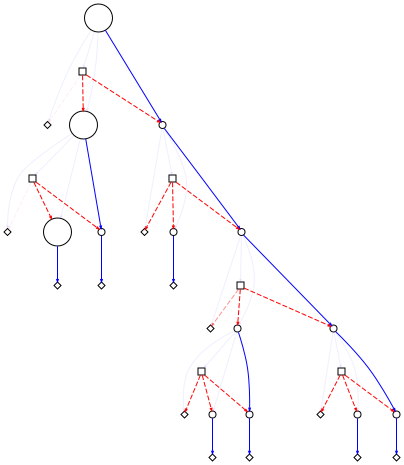

In [63]:
jet_id = np.argmin([len(jet["tree"]) if len(jet["tree"]) > 12 else 1000 for jet in X])
plot_jet(params, X[jet_id], index=2)